# Project: Segmentation of space objects

## 1. Problem Statmenet

You are a CV specialist at a startup, tasked with building a model to predict the trajectory of active space objects to avoid collisions with space debris. Your task is to segment images of artificial satellites and space stations, achieving an mIoU metric value of >70% on the validation set.

## 2. Import Libraries and Define Constants

In [116]:
import albumentations as A
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

import matplotlib.pyplot as plt
import numpy as np
import os

from PIL import Image
from tqdm import tqdm

from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from torchvision.models.segmentation import deeplabv3_resnet50
from sklearn.model_selection import train_test_split

is_debug_mode = True
print('Mode:', 'debug' if is_debug_mode else 'release')

img_size = 256 if is_debug_mode else 512
print('Image size: ', img_size)

num_epochs = 5 if is_debug_mode else 20
print('Num epochs:', num_epochs)

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

batch_size = 4

images_dir = 'data/images/'
mask_dir = 'data/mask/'

Mode: debug
Image size:  256
Num epochs: 5
Using device: mps


## 3. Loading Data

Define a custom dataset to load satelites data.

In [117]:
class SattDataset(Dataset):
    def __init__(self, image_dir, mask_dir, split="train", transform=None):
        self.images_filenames = os.listdir(image_dir + split) 
        self.transform = transform
        
        self.image_dir = image_dir + split
        self.mask_dir = mask_dir + split

        self.normalize = T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )


    def __len__(self):
        return len(self.images_filenames)


    def __getitem__(self, idx):
        image_name = self.images_filenames[idx]
        mask_name = image_name.replace('.png', '_mask.png')

        image = Image.open(os.path.join(self.image_dir, image_name)).convert("RGB")
        mask  = Image.open(os.path.join(self.mask_dir, mask_name)).convert("RGB")
        
        image_np = np.array(image)
        mask_np  = np.array(mask)

        if self.transform:
            augmented = self.transform(image=image_np, mask=mask_np)
            image = augmented["image"]
            mask  = augmented["mask"]

        # To Tensor
        image = TF.to_tensor(image)
        image = self.normalize(image)

        mask = TF.to_tensor(mask).squeeze(0)
        
        return image, mask

Define transformations for traning and validation; and augmentations for training.

In [118]:
train_transform = A.Compose([
    A.Resize(img_size, img_size),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
], additional_targets={'mask': 'mask'})

val_transform = A.Compose([
    A.Resize(img_size, img_size)
], additional_targets={'mask': 'mask'})

Loading datasets and defining data loaders.

For development and debugging I use Subsets of data to get results faster.

In [119]:
dataset_train = SattDataset(
    images_dir, 
    mask_dir, 
    transform=train_transform,
    split="train"
)
if is_debug_mode:
    dataset_train = torch.utils.data.Subset(dataset_train, range(400))

dataset_val = SattDataset(
    images_dir, 
    mask_dir, 
    transform=val_transform,
    split="val"
)
if is_debug_mode:
    dataset_val = torch.utils.data.Subset(dataset_val, range(100))

train_loader = DataLoader(dataset_train, batch_size=4, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=4, shuffle=False)

Training dataset


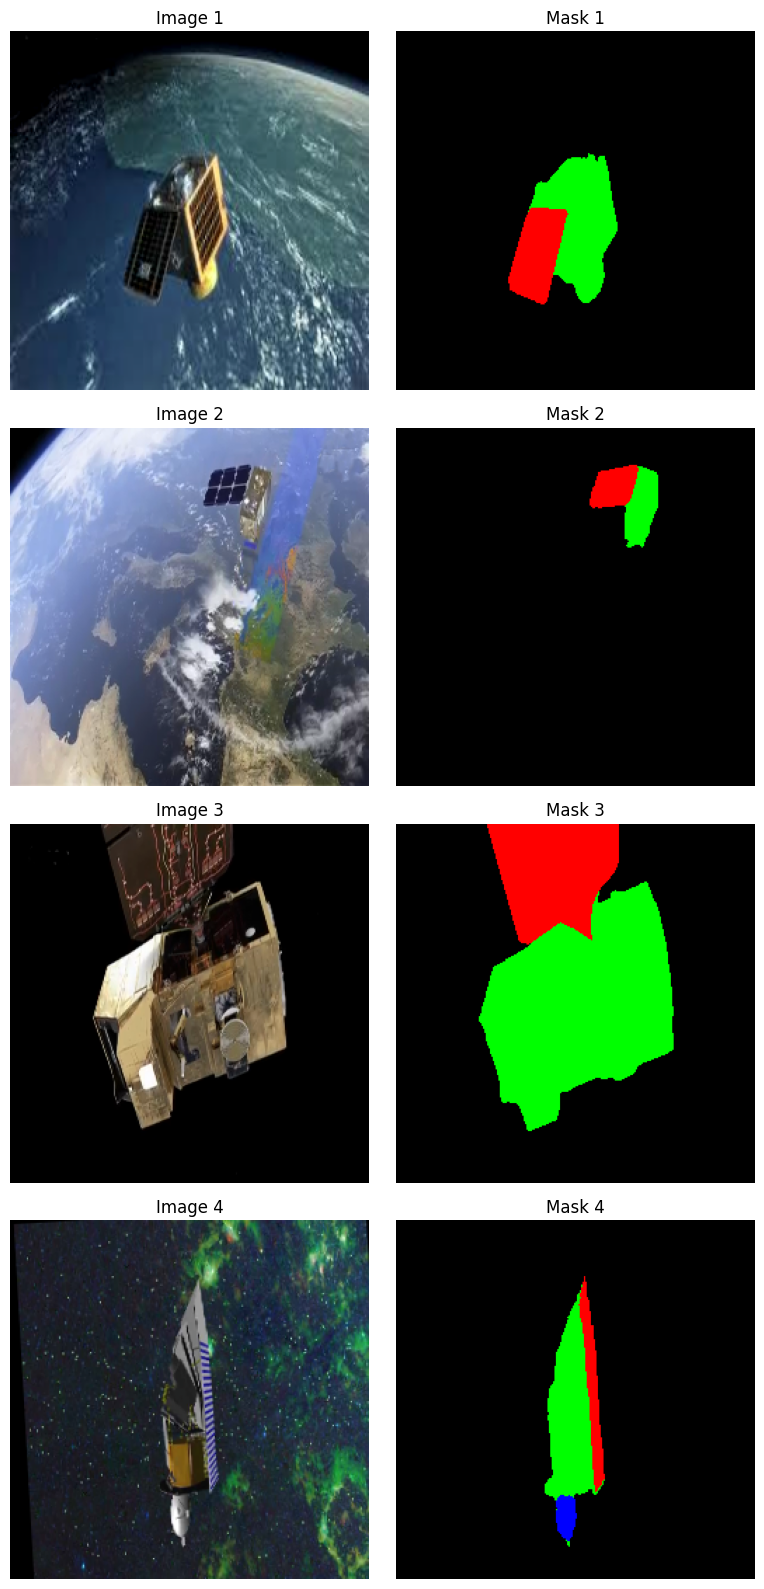

Validation dataset


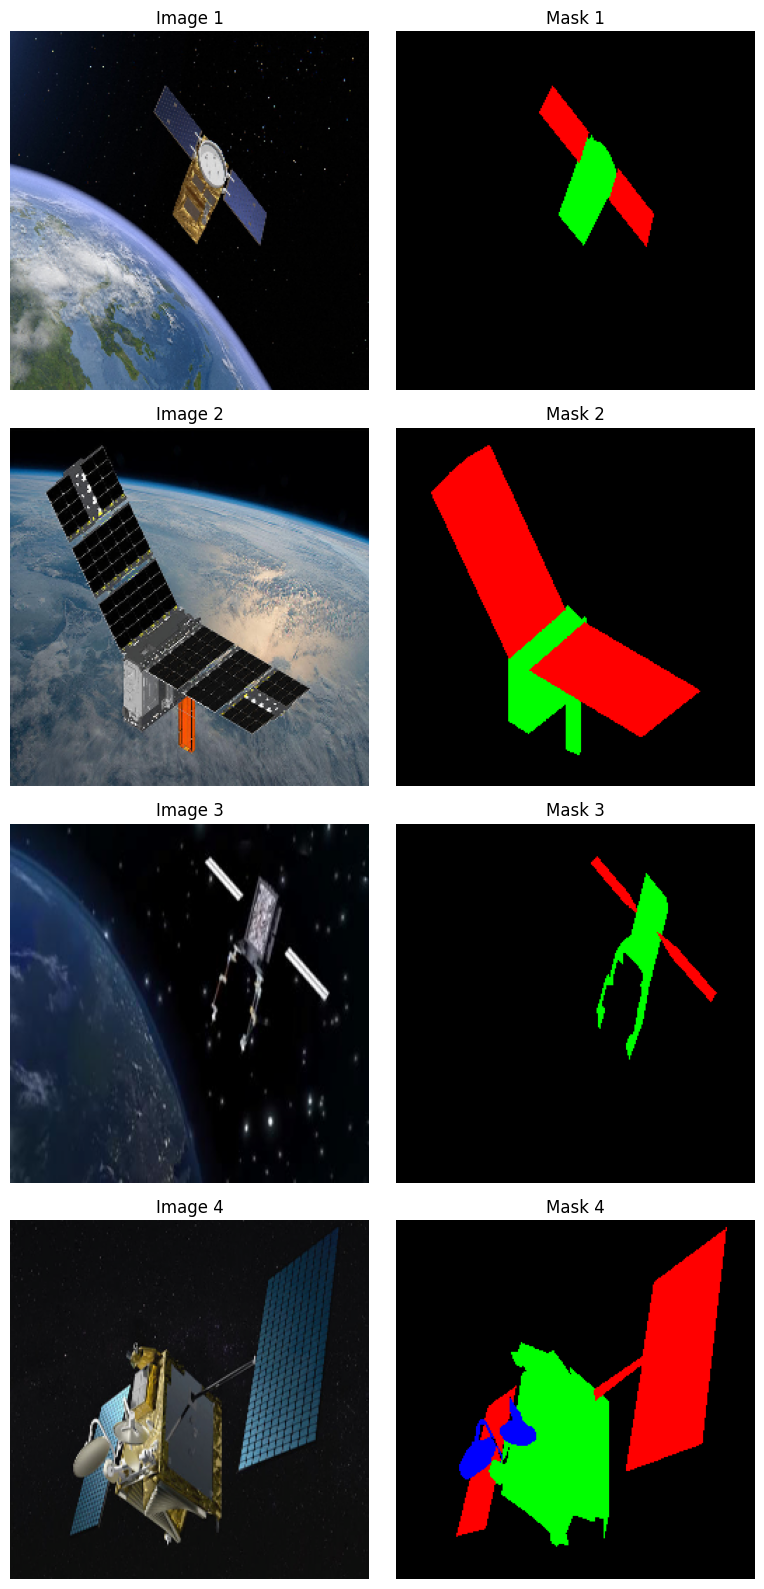

In [120]:
def plot_samples(dataset, num_samples=4):
    fig, axes = plt.subplots(4, 2, figsize=(8, 16))

    for i in range(num_samples):
        image, mask = dataset[i]
        
        # image is a tensor [C,H,W] normalized; denormalize for display
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])

        image_np = image.permute(1, 2, 0).numpy()
        image_np = (image_np * std + mean).clip(0, 1)
        
        mask_np = mask.permute(1, 2, 0).numpy()
        
        axes[i, 0].imshow(image_np)
        axes[i, 0].set_title(f"Image {i+1}")
        axes[i, 0].axis("off")
        
        axes[i, 1].imshow(mask_np)
        axes[i, 1].set_title(f"Mask {i+1}")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

print("Training dataset")
plot_samples(dataset_train)
print("Validation dataset")
plot_samples(dataset_val)


## 4. Defining the Model

DeepLabV3-ResNet50 has been chosen: it is suitable for this segmentation task because it provides strong performance through multi-scale feature extraction using atrous convolutions and ASPP. The ResNet-50 backbone offers a good balance between accuracy and computational efficiency, enabling effective training even on moderately sized datasets. Overall, the model delivers reliable segmentation quality while maintaining reasonable training and inference speed.

In [121]:
model = deeplabv3_resnet50(weights=None, num_classes=3)
model.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

Defining the loss function and the optimizer.

In [122]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

IoU metric calculation.

In [123]:
def iou_score(outputs, masks):
    # outputs: [B, C, H, W] logits
    # masks:   [B, C, H, W] one-hot

    pred = torch.argmax(outputs, dim=1)  # [B,H,W]
    target = torch.argmax(masks, dim=1)  # [B,H,W]

    intersection = ((pred == target) & (target > 0)).sum().float()
    union = ((pred > 0) | (target > 0)).sum().float()

    if union == 0:
        return torch.tensor(1.0, device=outputs.device)

    return intersection / union


## 5. Training and Validation

In [124]:
for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    train_loss = 0
    train_iou  = 0

    for images, masks in tqdm(train_loader):
        images = images.to(device)
        masks  = masks.to(device)

        optimizer.zero_grad()

        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_iou  += iou_score(outputs, masks).item()

    train_loss /= len(train_loader)
    train_iou  /= len(train_loader)

    # ---- Validation ----
    model.eval()
    val_loss = 0
    val_iou  = 0

    with torch.no_grad():
        for images, masks in tqdm(val_loader):
            images = images.to(device)
            masks  = masks.to(device)

            outputs = model(images)['out']
            loss = criterion(outputs, masks)

            val_loss += loss.item()
            val_iou  += iou_score(outputs, masks).item()

    val_loss /= len(val_loader)
    val_iou  /= len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train IoU: {train_iou:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val IoU: {val_iou:.4f}")


100%|██████████| 25/25 [00:05<00:00,  4.38it/s]


Epoch 1/5 | Train Loss: 0.0864 | Train IoU: 0.0895 | Val Loss: 0.1026 | Val IoU: 0.1198


100%|██████████| 25/25 [00:05<00:00,  4.35it/s]


Epoch 2/5 | Train Loss: 0.0598 | Train IoU: 0.1034 | Val Loss: 0.0711 | Val IoU: 0.1402


100%|██████████| 25/25 [00:05<00:00,  4.17it/s]


Epoch 3/5 | Train Loss: 0.0444 | Train IoU: 0.1107 | Val Loss: 0.0894 | Val IoU: 0.1272


100%|██████████| 25/25 [00:05<00:00,  4.19it/s]


Epoch 4/5 | Train Loss: 0.0392 | Train IoU: 0.1134 | Val Loss: 0.1155 | Val IoU: 0.1366


100%|██████████| 25/25 [00:05<00:00,  4.36it/s]

Epoch 5/5 | Train Loss: 0.0343 | Train IoU: 0.1183 | Val Loss: 0.0937 | Val IoU: 0.1540


## Обучение модели

 
1.   Реализуйте выбранную вами модели instance segmentation
2.   Обучите модель
3.   Сравните разные метрики instance segmentation, включая mIoU

